In [1]:
import sys
sys.path.insert(0, '../')
from transformer.GPTModel import GPTModel, GPTConfig

In [3]:
import torch
import torch.nn as nn
import math

torch.manual_seed(1337)

# context length is 3, so we take 3 bits to predict the next bit probability
context_length = 3
config = GPTConfig(
    PosEmbedDim = context_length,
    # vocab size is 2, so we only have two possible tokens: 0,1
    VocabSize = 2,
    BlockNum = 4,
    HeadNum = 4,
    EmbedDim = 16,
    EnableBias = False,
)
gpt = GPTModel(config)
#gpt.PrintNumParameters()
#gpt.TraversePrintParameters()
#gpt.TraversePrintModuleInfo()

In [4]:
def all_possible(n, k):
    # return all possible lists of k elements, each in range of [0,n)
    if k == 0:
        yield []
    else:
        for i in range(n):
            for c in all_possible(n, k - 1):
                yield [i] + c
list(all_possible(config.VocabSize, config.PosEmbedDim))

[[0, 0, 0],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 1],
 [1, 0, 0],
 [1, 0, 1],
 [1, 1, 0],
 [1, 1, 1]]

tensor([[0, 0, 0]])
input [0, 0, 0] ---> [0.49561360478401184, 0.5043864250183105]
tensor([[0, 0, 1]])
input [0, 0, 1] ---> [0.44780123233795166, 0.5521987676620483]
tensor([[0, 1, 0]])
input [0, 1, 0] ---> [0.4962039887905121, 0.5037960410118103]
tensor([[0, 1, 1]])
input [0, 1, 1] ---> [0.4480619728565216, 0.551937997341156]
tensor([[1, 0, 0]])
input [1, 0, 0] ---> [0.49629056453704834, 0.5037093758583069]
tensor([[1, 0, 1]])
input [1, 0, 1] ---> [0.4480663537979126, 0.5519336462020874]
tensor([[1, 1, 0]])
input [1, 1, 0] ---> [0.49690738320350647, 0.5030925869941711]
tensor([[1, 1, 1]])
input [1, 1, 1] ---> [0.4483327865600586, 0.5516672134399414]


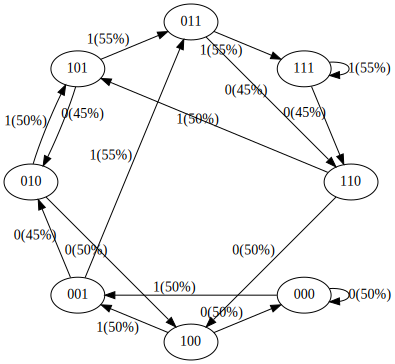

In [6]:
from torch.nn import functional as F

from graphviz import Digraph

def plot_model():
    dot = Digraph(comment='Baby GPT', engine='circo')

    for xi in all_possible(gpt.config.VocabSize, gpt.config.PosEmbedDim):
        
        # forward the GPT and get probabilities for next token
        x = torch.tensor(xi, dtype=torch.long)[None, ...] # turn the list into a torch tensor and add a batch dimension
        logits = gpt(x) # forward the gpt neural net
        probs = F.softmax(logits, dim=-1) # get the probabilities
        y = probs[0].tolist() # remove the batch dimension and unpack the tensor into simple list
        print(f"input {xi} ---> {y}")

        # also build up the transition graph for plotting later
        current_node_signature = "".join(str(d) for d in xi)
        dot.node(current_node_signature)
        for t in range(gpt.config.VocabSize):
            next_node = xi[1:] + [t] # crop the context and append the next character
            next_node_signature = "".join(str(d) for d in next_node)
            p = y[t]
            label=f"{t}({p*100:.0f}%)"
            dot.edge(current_node_signature, next_node_signature, label=label)
    
    return dot

plot_model()